    First, let's try to import the data directly from the web. We load the requisite libraries below.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [255]:
# Load dataframe
data = pd.read_csv('Arrest_Data_from_2010_to_Present.csv')

# One way to see all the years is to convert 'Arrest Date' to DatetimeIndex type and extract the year.
years = pd.DatetimeIndex(data['Arrest Date']).year

# Add 'Arrest Year' as a column
data['Arrest Year'] = years

In [14]:
"""
    How many bookings of arrestees were made in 2018?
"""
nArrestees2018 = len(data[data['Arrest Year'] == 2018])
print("{} bookings were made in 2018.".format(nArrestees2018))

104277 bookings were made in 2018.


In [15]:
"""
    How many bookings of arrestees were made in the area with the most arrests in 2018?
""" 

# Create new data frame which is a subset of the original where arrest year is 2018
data_2018 = data[data['Arrest Year'] == 2018]

# Count the unique occurrences of Area IDs
nBookingsMaxArea = data_2018["Area ID"].value_counts().max()
print("{} bookings were made in the area with the most arrests.".format(nBookingsMaxArea))

10951 bookings were made in the area with the most arrests.


In [19]:
"""
    What is the 95% quantile of the age of the arrestee in 2018? Only consider the following charge groups
    for your analysis: Vehicle Theft, Robbery, Burglary and Receive Stolen Property

    Create a data frame that is a subset of the 2018 data where 'Charge Group Description' 
    matches the aforementioned offenses
"""

charge_groups = data_2018[(data_2018['Charge Group Description']=='Vehicle Theft') | \
                          (data_2018['Charge Group Description']=='Robbery') | \
                          (data_2018['Charge Group Description']=='Receive Stolen Property') | \
                          (data_2018['Charge Group Description']=='Burglary')] 

# Use the pandas quantile function to determine the quantile
age95thquantile = charge_groups['Age'].quantile(0.95)
print("The age of the 95th quantile is {}.".format(age95thquantile))
# NOTE - This analysis includes attempted burglary...

The age of the 95th quantile is 52.0.


In [57]:
""" 
    There are differences between the average age of an arrestee for the various charge groups. 
    Are these differences statistically significant? 
    For this question, calculate the Z-score of the average age for each charge group. 
    Report the largest absolute value among the calculated Z-scores.
    
    Only consider data for 2018
    Do not consider "Pre-Delinquency" and "Non-Criminal Detention" as these charge groups are reserved for minors
    Exclude any arrests where the charge group description is not known

"""
# Subset the data to exclude 'Pre-Delinquency', 'Non-Crimal Detention' and 'NA' offenses.
cg2 = data_2018[(data_2018['Charge Group Description'] != 'Pre-Delinquency') & \
                (data_2018['Charge Group Description'] != 'Non-Criminal Detention') & \
                (data_2018['Charge Group Code'] != 99.0)]

# Remove NAN values
cg2 = cg2.dropna(subset=['Charge Group Description'])

# Calculate the mean age of all offenders
age_mean = cg2["Age"].mean()
age_std = cg2["Age"].std()

# We next need to iterate through each of the charge group values and determine the 
# average age associated with each
labels = cg2["Charge Group Code"].unique()
z_vals = np.zeros(labels.shape)

for i_label, v_label in enumerate(labels):
    z_vals[i_label] = (cg2['Age'][cg2['Charge Group Code'] == v_label].mean() - age_mean)/age_std

# Return the largest z-val    
zscoremax = np.max(np.abs(z_vals))  
print("The largest absolute Z-score is {}.".format(zscoremax))
 

The largest absolute Z-score is 0.6934284004664495.


The estimated number of felony arrests in 2019 is 31037


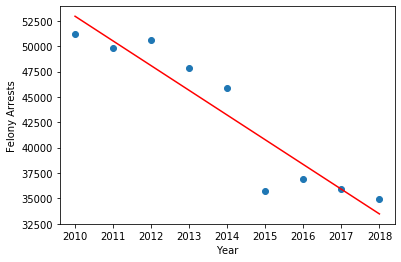

In [82]:
"""
    Felony arrest incidents have been dropping over the years. 
    Using a trend line (linear estimation) for the data from 2010 and 2018 (inclusive), 
    what is the projected number of felony arrests in 2019? 
    Round to the nearest integer. 
    
    Note, the data set includes arrests for misdemeanor, felonies, etc.
    
"""

# Initialize numpy arrays to contain the dates and number of felony arrests
all_years = np.arange(2010, 2019)
felony_arrests = np.zeros(all_years.shape)

# Felonies have 'Arrest Type Code' = F. Count the number of felonies for a given year.
for iyear, ayear in enumerate(all_years):
    felony_arrests[iyear] = len(data[(data['Arrest Year'] == ayear) & (data['Arrest Type Code'] == 'F')])
    
# Compute linear fit to data
m, b = np.polyfit(all_years, felony_arrests, 1)
    
# Plot the data, linear fit
plt.figure()
plt.plot(all_years, felony_arrests, 'o', label='Data')
plt.plot(all_years, m*all_years + b, 'r-', label='Fit')
plt.xlabel('Year')
plt.ylabel('Felony Arrests')

print("The estimated number of felony arrests in 2019 is {}".format(int(m*2019+b)))

In [174]:
"""
    How many arrest incidents occurred within 2 km from the Bradbury Building in 2018? 
    Use (34.050536, -118.247861) for the coordinates of the Bradbury Building . 
    For simplicity, please use the spherical Earth projected to a plane equation for calculating distances. 
    Use the radius of the Earth as 6371 km. 

    Note, some arrest records are missing location data and the location is listed as (0, 0). 
    These records should not factor in your calculation.

"""

rmin2 = 2**2. # squared minimum distance
rE2 = 6371**2 # squared radius of Earth [km**2]
A = 34.050536 # latitude of Bradbury Building, [degrees]
B = -118.247861 # longitude of Bradbury Building, [degrees]

all_coords = []
d2 = np.zeros(len(data[data['Arrest Year'] == 2018]))

# Iterate through coordinates in 'Location' column
for index, coords in enumerate(data['Location'][data['Arrest Year'] == 2018]):
    
    # Combine numerical values (including period and hyphen) intro string, 
    # separated by spaces for all other characters
    coords_ = ''.join((ch if ch in r'-0123456789.' else ' ') for ch in coords)   
    
    # Create a 2-element list of floats, split by the space character
    coords_ = [float(i) for i in coords_.split()]
    A_, B_ = coords_[0], coords_[1]
    
    if A_ == 0 and B_ == 0:
        # Exclude (0, 0) coordinates from calculation 
        d2[index] = np.nan
    else:
        phi_m = (A + A_)/2.0  # Mean latitude [degrees]
        dphi = np.pi*(A_ - A)/180.  # Difference of latitudes [radians]
        dlam = np.pi*(B_ - B)/180.  # Difference of longitudes [radians]
        d2[index] = rE2*(dphi**2 + (np.cos(np.pi*phi_m/180)*dlam)**2)

# Use logical indexing to select all non-nan squared distances less than rmin2        
inRadius = d2[np.logical_and(~np.isnan(d2), d2<rmin2)]
N_withinRadius = len(inRadius)

print("Of the {} arrests made in 2018, {} were within 2 km of Bradbury building".format(len(d2), N_withinRadius))

Of the 104277 arrests made in 2018, 11461 were within 2 km of Bradbury building


/Users/dalixwill/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


In [223]:
"""
    How many arrest incidents were made per kilometer on Pico Boulevard during 2018? 
    For this question, we will need to estimate the length of Pico Boulevard, 
    which mostly stretches from east to west. To estimate the length of Pico Boulevard:

        Consider all location data which the listed address mentions "Pico".
        Remove outliers by filtering out locations where either the latitude or longitude 
        is 2 standard deviations beyond the mean of the subset of identified points.
        To estimate the length, calculate the distance from the most western and eastern coordinate points. 
        Use the spherical Earth projected to a plane equation for calculating distances.

    Once you have estimated the length of Pico Boulevard, 
    you can proceed to report the number of arrest incidents per kilometer on Pico Boulevard in 2018.

"""

# First, see what events occured on Pico Boulevard in 2018 and save to new dataframe
#data_pico2018 = data[(data["Cross Street"] == 'PICO') & \
#                (data["Arrest Year"] == 2018)]
data_pico2018 = data[(data['Address'].str.contains("PICO")) &\
                            (data['Arrest Year'] == 2018)]

# Initialize empty numpy arrays to store lattitude, longitude data
pico_lat = np.zeros(len(data_pico2018))
pico_lon = np.zeros(len(data_pico2018))

# Iterate through coordinates in 'Location' column of this dataframe
for index, coords in enumerate(data_pico2018['Location']):
    
    # Get corresponding numerical values (floating point values) of coordinates
    coords_ = ''.join((ch if ch in r'-0123456789.' else ' ') for ch in coords)
    
    # Create 2-element list of floats, split by the space character
    coords_ = [float(i) for i in coords_.split()]
    
    # Save lattitude, longitude values
    pico_lat[index] = coords_[0]
    pico_lon[index] = coords_[1]

# Calculate z-scores of lattitude, longitude
z_lat = (pico_lat - np.mean(pico_lat))/np.std(pico_lat)
z_lon = (pico_lon - np.mean(pico_lon))/np.std(pico_lon)

# Create boolean array where values are all True, unless abs(z_lat or z_lon) > 2
z_com = np.ones(z_lat.shape, dtype=bool)
z_com[np.logical_or(np.abs(z_lat)>2, np.abs(z_lon)>2)] = False

# Now must determine most eastern and western point from dataset, index
east = np.amin(pico_lon[z_com])
ieast = np.argmin(pico_lon[z_com])
west = np.amax(pico_lon[z_com])
iwest = np.argmax(pico_lon[z_com])

phi1 = pico_lat[z_com][ieast]
lam1 = pico_lon[z_com][ieast]

phi2 = pico_lat[z_com][iwest]
lam2 = pico_lon[z_com][iwest]

dphi = (phi1-phi2)*np.pi/180
dlam = (lam1-lam2)*np.pi/180
phim = (phi1+phi2)*np.pi/2/180

print("The most eastern and western points are at latitudes {} and {}, respectively.".format(east, west))

# Now calculate the distance between these points
l_pico = 6371*np.sqrt((dphi)**2 + (np.cos(phim)*dlam)**2)
print("The approximate length of PICO street is {} km.".format(l_pico))

# Calculate the average number of arrests 
print("Their were approximately {} arrests per km on Pico Boulevard in 2018.".format(l_pico/len(z_com[z_com==True])))

The most eastern and western points are at latitudes -118.453 and -118.2159, respectively.
The approximate length of PICO street is 21.875430097184957 km.
Their were approximately 0.036157735697826376 arrests per km on Pico Boulevard in 2018.


In [251]:
"""
    Some types of arrest incidents in certain areas occur at a highly disproportionate 
    rate compared to their frequency city-wide. For example, let's say that the rate of 
    larceny arrests (charge group code 6) is 1% in Devonshire (area ID 17). 
    
    This rate may appear low but what if larceny arrests constitute 0.1 % city-wide? 
    The ratio between these two probabilities is 10 and we can say that larceny occurs 
    unusually often in Devonshire (Note, these numbers were made up for illustration purposes). 
    
    Calculate this ratio for all charge group code and area ID pairs. 
    You can view this ratio as the ratio of the conditional probability 
    of an arrest incident of a charge group code given that it occurred in an area ID to the 
    unconditional probability of the arrest incident of a charge group. 
    
    Report the average of the top 5 of the calculated ratio.
    
    
    Consider all records prior to January 1, 2019.
    Some arrest incidents don't have a charge group code. 
    These records should not be considered in your analysis.
    Arrest incidents for charge group code 99 should not be considered in your analysis.

"""

# Clean the data, removing 2019 data, missing charge code
clean_data = data[(data['Arrest Year'] != 2019) &\
                  (data['Charge Group Code'] != 99.0) &\
                  (data['Charge Group Code'].notnull())]

# Get a list of the area IDs, charge codes
areaIDs = clean_data['Area ID'].unique()
chargeCodes = clean_data['Charge Group Code'].unique()

propRatio = np.zeros((len(areaIDs), len(chargeCodes)))
totArrestsGlo = len(clean_data) # Total number of arrests city-wide

for iID, vID in enumerate(areaIDs):
    
    # Total number of arrests in a given area
    totArrestsLoc = len(clean_data[clean_data['Area ID'] == vID])
    
    for iCC, vCC in enumerate(chargeCodes):
        
        # Total number of arrests of a particular type in the area
        nArrestsLocCC = len(clean_data[(clean_data['Area ID'] == vID) & \
                                       (clean_data['Charge Group Code'] == vCC)])
        
        # Total number of arrests of a particular type city-wide
        nArrestsGloCC = len(clean_data[clean_data['Charge Group Code'] == vCC])
        
        
        propRatio[iID, iCC] = nArrestsLocCC*totArrestsGlo/totArrestsLoc/nArrestsGloCC
        
# Get the most highest probability offenses for each charge code        
freq_crimes = np.amax(propRatio, axis=0)

# Compute the average of the top 5 offenses
avgTop5 = np.mean(sorted(freq_crimes, reverse=True)[:5])
print("The average of the top 5 reported offenses is {}.".format(avgTop5))


The average of the top 5 reported offenses is 3.515076379865202.
